# SMO706- Big Data Wrangling 
Tim Hannigan Jan 15, 2019

In [329]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install statsmodels

import pandas as pd
import json
import requests
import datetime as dt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import numpy as np
import statsmodels.api as sm

### Main methods

#### Western Canadian Select Oil Price

In [235]:
# first, load the data
file_name = "USCRWCAS_dailyPrice.xlsx"

In [236]:
# next, process it into a DataFrame
df_wcs = pd.read_excel(file_name)
df_wcs.columns = [col.lower() for col in df_wcs.columns] # for ease of use, working with lowercase column names

In [237]:
# this lists the type of variables in the dataframe, note: there are 916 rows
df_wcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
date        252 non-null datetime64[ns]
uscrwcas    252 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [238]:
# a shorter way of inspecting this dataframe is by looking at the shape
df_wcs.shape

(252, 2)

In [239]:
# next, inspect the first 5 rows of the data
df_wcs.head(5)

,date,uscrwcas
0,2019-01-14,43.73
1,2019-01-11,44.64
2,2019-01-10,44.74
3,2019-01-09,43.86
4,2019-01-08,40.78


In [240]:
# in order to make this easier to manage, we'll set the index to be the date
df_wcs['date'] = pd.to_datetime(df_wcs['date']) # setting column with 'date' type

In [241]:
# setting the index as date
df_wcs.set_index('date', inplace=True)

In [242]:
# ordering by index (ascending order)
df_wcs.sort_index(axis=0, ascending=True, inplace=True)

In [243]:
# check to see it's working properly
df_wcs.head(2)

,uscrwcas
date,
2018-01-16,42.73
2018-01-17,40.17


In [244]:
# check to see it's working properly
df_wcs.tail(2)

,uscrwcas
date,
2019-01-11,44.64
2019-01-14,43.73


In [245]:
# change name of column to make it easier
df_wcs.columns=["wcs"]

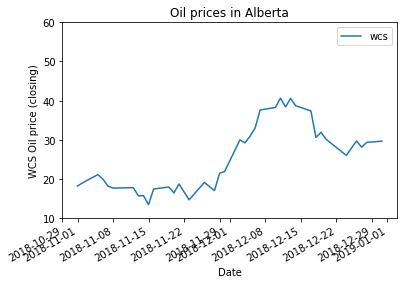

In [246]:
# plotting the late 2018 data
df_wcs.loc['Nov 1, 2018':'Dec 31, 2018', ['wcs']].plot()
plt.ylim(10,60)
plt.xlabel('Date')
plt.ylabel('WCS Oil price (closing)')
plt.title('Oil prices in Alberta')
plt.show()

#### Collect news stories about Alberta + Oil

In [91]:
articles = []
for i in range(1,8):
    with open ("Factiva_major_Canada_news/Factiva"+str(i)+".html", "r") as file: 
        html_doc = file.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    # in analyzing the HTML source, each story is contained in a div called "article enArticle"
    articleContainers = soup.find_all("div", "article enArticle")
    for articleContainer in articleContainers:
        table = articleContainer.find('table')
        #print (table)        
        headline_text = table.find_all("span", "enHeadline")[0].text
        rows = table.find_all('tr')
        article_text = ""
        for row in rows:
            cols = row.find_all('td')
            if cols[0].text.strip()=="BY": 
                author_text = cols[1].text   
            elif cols[0].text.strip()=="PD": 
                date_text = cols[1].text
                date = pd.to_datetime(date_text) # convert to a date object
            elif cols[0].text.strip()=="LP": # lead paragraph
                article_text += " " + cols[1].text
            elif cols[0].text.strip()=="TD": # content
                article_text += " " + cols[1].text         
        articles.append({"headline": headline_text, "author":author_text, "date": date, "text":article_text })

In [92]:
df_articles = pd.DataFrame(articles)

In [93]:
df_articles.shape

(629, 4)

In [217]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 4 columns):
author      629 non-null object
date        629 non-null object
headline    629 non-null object
text        629 non-null object
dtypes: object(4)
memory usage: 19.7+ KB


#### Now, extract some topics using LDA topic modeling analysis

In [158]:
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk



# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# spacy for lemmatization
import spacy

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [159]:
stop_words = stopwords.words('english')
stop_words.extend(["http", "https","www", "com", "say", "said"])

In [160]:
# Convert to list
data = df_articles.text.values.tolist()

In [161]:
# tokenize words and clean up text using Gensim’s simple_preprocess() method
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [162]:
# Creating Bigram Models
#Some examples in our example are: ‘alberta_oipatch’, ‘oil_leak’, 'cannabis_oil'

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [163]:
###Remove Stopwords, Make Bigrams and Lemmatize

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [164]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [165]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [166]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# run stop word again, post lemmatization
data_lemmatized = [[word for word in doc if word not in stop_words] for doc in data_lemmatized] 

print(data_lemmatized[0])

['angry', 'albertan', 'strike', 'sound', 'mad', 'hell', 'go', 'take', 'anymore', 'rest', 'canada', 'owe', 'big', 'time', 'trudeau', 'deliberately', 'wreck', 'province', 'exactly', 'smart', 'way', 'win', 'heart', 'mind', 'country', 'anger', 'way', 'blot', 'intelligence', 'regardless', 'certainly', 'lot', 'explosive', 'anger', 'alberta', 'day', 'lot', 'people', 'know', 'better', 'willing', 'throw', 'match', 'anger', 'stem', 'frustration', 'stall', 'oil', 'pipeline', 'construction', 'pipeline', 'suppose', 'ship', 'alberta', 'plentiful', 'oil', 'supply', 'united_state', 'export', 'market', 'limbo', 'mainly', 'objection', 'environmental', 'indigenous', 'activist', 'uphold', 'court', 'combine', 'complication', 'oil', 'market', 'mean', 'alberta', 'oil', 'fetching', 'next', 'nothing', 'compare', 'usual', 'benchmark', 'price', 'understandably', 'make', 'lot', 'people', 'mad', 'many', 'depend', 'thrive', 'oil', 'industry', 'well', 'pay', 'work', 'surprising', 'see', 'large', 'protest', 'rally', 

In [136]:
# Dictionary and Corpus needed for Topic Modeling

In [175]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus_bag_of_words = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[0])

In [176]:
len(id2word)

24162

In [177]:
# this creates a unique id for each word in each document; what you're seeing above is [word_id, wordfrequency]
id2word[0]
# therefore, 'abandon' only appears once

'absurdly'

In [178]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus_bag_of_words[0:1]]

#### How to find the optimal number of topics for LDA?

In [179]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Compute Coherence Score        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)                        
        model_list.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')        
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
        print ("trying out, ", num_topics, "topics", "coherence_lda=", coherence_lda)
    return model_list, coherence_values

In [180]:
limit=50; start=5; step=5;

In [181]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_bag_of_words, texts=data_lemmatized, start=start, limit=limit, step=step)

trying out,  5 topics coherence_lda= 0.4445338316845241
trying out,  10 topics coherence_lda= 0.44678389878627556
trying out,  15 topics coherence_lda= 0.4717798928761202
trying out,  20 topics coherence_lda= 0.4685493648590066
trying out,  25 topics coherence_lda= 0.49516590910466646
trying out,  30 topics coherence_lda= 0.482585538609575
trying out,  35 topics coherence_lda= 0.478726749588953
trying out,  40 topics coherence_lda= 0.4640999942267091
trying out,  45 topics coherence_lda= 0.46004050637481214


In [182]:
coherence_values

[0.4445338316845241,
 0.44678389878627556,
 0.4717798928761202,
 0.4685493648590066,
 0.49516590910466646,
 0.482585538609575,
 0.478726749588953,
 0.4640999942267091,
 0.46004050637481214]

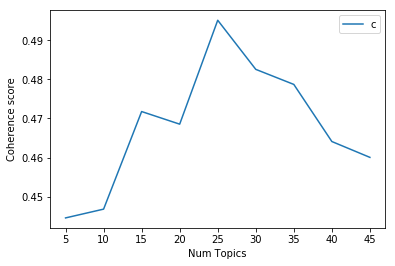

In [194]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [195]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4445
Num Topics = 10  has Coherence Value of 0.4468
Num Topics = 15  has Coherence Value of 0.4718
Num Topics = 20  has Coherence Value of 0.4685
Num Topics = 25  has Coherence Value of 0.4952
Num Topics = 30  has Coherence Value of 0.4826
Num Topics = 35  has Coherence Value of 0.4787
Num Topics = 40  has Coherence Value of 0.4641
Num Topics = 45  has Coherence Value of 0.46


In [196]:
idealNumberOfTopics =  35

In [197]:
# Build LDA model
lda_model_optimal = gensim.models.ldamodel.LdaModel(corpus=corpus_bag_of_words,
                                           id2word=id2word,
                                           num_topics= idealNumberOfTopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [198]:
# Print the Keyword in the topics
topic_output = lda_model_optimal.print_topics(idealNumberOfTopics)

for topicTuple in topic_output:
    index = topicTuple[0]+1 # recall that list indices start at 0
    print ("Topic:", index, "\n\t", topicTuple[1])

Topic: 1 
	 0.041*"ce" + 0.024*"strad" + 0.018*"pan_orient" + 0.016*"ebit" + 0.015*"property_plant" + 0.015*"thailand_joint" + 0.014*"annuity_maintenance" + 0.013*"petrus" + 0.013*"enerflex" + 0.012*"industrial_matt"
Topic: 2 
	 0.027*"company" + 0.019*"information" + 0.018*"statement" + 0.011*"may" + 0.011*"include" + 0.010*"forward_look" + 0.010*"result" + 0.008*"financial" + 0.008*"boe" + 0.008*"well"
Topic: 3 
	 0.095*"page" + 0.042*"doodle" + 0.032*"miller" + 0.024*"mat" + 0.021*"tyrrell" + 0.016*"explore" + 0.011*"showroom" + 0.010*"googler" + 0.010*"badland" + 0.010*"albertosaurus"
Topic: 4 
	 0.018*"creditor" + 0.010*"bankrupt" + 0.006*"insolvent" + 0.006*"gettis" + 0.005*"coal_mine" + 0.003*"escrow" + 0.002*"toughening" + 0.001*"nobb" + 0.000*"sliver" + 0.000*"arrear"
Topic: 5 
	 0.019*"court" + 0.018*"law" + 0.013*"security" + 0.011*"commercial_litigation" + 0.009*"lawyer" + 0.009*"trial" + 0.009*"practice_focus" + 0.009*"counselling" + 0.007*"appeal" + 0.007*"product_liabili

In [199]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimal, corpus_bag_of_words, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.136314  0.028766       1        1   0.391364
1      0.236187  0.163041       2        1   8.938945
2     -0.175170  0.000188       3        1   0.116403
3     -0.178133 -0.009822       4        1   0.014623
4     -0.119874  0.016809       5        1   0.890636
5      0.027500 -0.002155       6        1   0.649794
6      0.285778  0.211016       7        1   8.682945
7     -0.181069 -0.005287       8        1   0.056438
8      0.044249 -0.123447       9        1   2.190236
9      0.308875 -0.042514      10        1  22.583351
10     0.232202 -0.185846      11        1   9.237591
11     0.139842 -0.080989      12        1   2.511245
12     0.012415  0.156246      13        1   0.770522
13    -0.083363  0.024045      14        1   0.500078
14    -0.125957 -0.006115      15        1   0.274532
15    -0.136182  0.011825      16        1   0.469467
16     0.182840 -0.174904      17        1  11.467810
17    -0.043689  0.082675      18        1   0.456881
18    -0.180146 -0.003870      19        1   0.018122
19    -0.176124  0.003422      20        1   0.039103
20     0.291300  0.086884      21        1   9.990149
21    -0.173674  0.008513      22        1   0.118701
22     0.194627  0.209937      23        1   2.530121
23    -0.142087  0.010995      24        1   0.333496
24     0.239523  0.084608      25        1   2.893582
25     0.091860 -0.067262      26        1   1.285466
26    -0.179302 -0.007781      27        1   0.026937
27     0.011251  0.064492      28        1   0.575493
28    -0.153351  0.005065      29        1   0.293955
29    -0.161178  0.008645      30        1   0.174596
30     0.066886 -0.126004      31        1   1.706105
31     0.118589 -0.221803      32        1   4.602576
32    -0.179033  0.002416      33        1   0.082068
33     0.200114 -0.131928      34        1   4.896838
34    -0.159389  0.010138      35        1   0.229825, topic_info=      Category         Freq                   Term        Total  loglift  \
term                                                                       
167    Default  3380.000000                    oil  3380.000000  30.0000   
359    Default  1734.000000               per_cent  1734.000000  29.0000   
5020   Default  1561.000000                  photo  1561.000000  28.0000   
46     Default  2565.000000                company  2565.000000  27.0000   
5611   Default  1380.000000        theglobeandmail  1380.000000  26.0000   
11     Default  1097.000000                article  1097.000000  25.0000   
189    Default  1771.000000                  price  1771.000000  24.0000   
149    Default  1757.000000                 market  1757.000000  23.0000   
33     Default  3392.000000                 canada  3392.000000  22.0000   
312    Default  1411.000000                 energy  1411.000000  21.0000   
266    Default  1120.000000                   well  1120.000000  20.0000   
192    Default   886.000000               province   886.000000  19.0000   
394    Default  2852.000000                   year  2852.000000  18.0000   
107    Default   819.000000                    gas   819.000000  17.0000   
2      Default  2049.000000                alberta  2049.000000  16.0000   
7063   Default   833.000000              sent_word   833.000000  15.0000   
763    Default   674.000000                   city   674.000000  14.0000   
176    Default   850.000000               pipeline   850.000000  13.0000   
1675   Default  1009.000000                   cost  1009.000000  12.0000   
3193   Default  1152.000000             production  1152.000000  11.0000   
480    Default  1021.000000                 result  1021.000000  10.0000   
893    Default   860.000000                project   860.000000   9.0000   
1002   Default   962.000000               increase   962.000000   8.0000   
129    Default   968.000000               industry   968.00

In [324]:
# from this, you can see that topic 23 is about production cuts in Alberta and OPEC, topic 7 is about increasing production, topic 10 is about pipelines

#### Looking at output from the LDA model

In [ ]:
# Reference: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

In [200]:
len(corpus_bag_of_words)

629

In [201]:
len(lda_model_optimal[corpus_bag_of_words])

629

#### Topic distribution across documents

In [202]:
topics_in_each_document = lda_model_optimal.get_document_topics(corpus_bag_of_words, per_word_topics=False, minimum_probability=0.0)
# this will output the relevant topics per document

In [203]:
# one probability weight for each topic in this document
topics_in_each_document[4]

[(0, 3.9594557e-05),
 (1, 0.0003969689),
 (2, 6.733274e-05),
 (3, 2.9071018e-05),
 (4, 8.443348e-05),
 (5, 0.00020547547),
 (6, 0.06148819),
 (7, 4.3595686e-05),
 (8, 0.00021169712),
 (9, 0.19122764),
 (10, 0.16264066),
 (11, 0.00023062261),
 (12, 0.00017399843),
 (13, 0.0001749166),
 (14, 0.02907594),
 (15, 0.00016830224),
 (16, 0.0014284326),
 (17, 0.00016949279),
 (18, 3.6919e-05),
 (19, 3.97158e-05),
 (20, 0.047067),
 (21, 0.008811401),
 (22, 0.00050843816),
 (23, 0.0001369409),
 (24, 0.00032061202),
 (25, 0.00018371126),
 (26, 3.4479715e-05),
 (27, 0.00012324826),
 (28, 0.00020926107),
 (29, 6.0467202e-05),
 (30, 0.00036221102),
 (31, 0.0002556759),
 (32, 3.9309056e-05),
 (33, 0.49389833),
 (34, 5.5880257e-05)]

In [204]:
# creating a document_topic_matrix for all topics, all documents

In [205]:
topic_document_matrix = []
for document_topics in topics_in_each_document:
    tdm = {}
    for topicFound in document_topics:
        topicID = topicFound[0]
        topicValue = topicFound[1]
        tdm[topicID] = topicValue # set value
    topic_document_matrix.append(tdm)
tdm_df = pd.DataFrame(topic_document_matrix)        

In [206]:
# change order of columns
columns = ["topic_"+str(i) for i in range(1,idealNumberOfTopics+1)]

In [207]:
tdm_df.columns = columns

In [208]:
tdm_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35
0,0.000034,0.005256,0.000057,0.000025,0.000072,0.000174,0.001465,0.000037,0.000180,0.365153,...,0.000156,0.000029,0.000105,0.000178,0.000051,0.028083,0.000217,0.000033,0.420537,0.000047
1,0.000052,0.000526,0.000089,0.000039,0.000112,0.000272,0.023942,0.000058,0.000281,0.597089,...,0.000244,0.000046,0.000163,0.000277,0.000080,0.000481,0.000339,0.000052,0.001492,0.000074
2,0.000046,0.000459,0.000078,0.000034,0.000098,0.000237,0.002228,0.000050,0.000245,0.152218,...,0.000212,0.000040,0.000142,0.000242,0.003490,0.066337,0.041136,0.000045,0.001177,0.000065
3,0.000100,0.001007,0.000171,0.000074,0.000214,0.000521,0.004990,0.000111,0.000537,0.365666,...,0.000466,0.000087,0.000313,0.000531,0.000153,0.000919,0.000648,0.000100,0.194657,0.000142
4,0.000040,0.000397,0.000067,0.000029,0.000084,0.000205,0.061491,0.000044,0.000212,0.191231,...,0.000184,0.000034,0.000123,0.000209,0.000060,0.000362,0.000256,0.000039,0.493898,0.000056


In [209]:
# this will calculate the dominant topic per document, recall this starts from 0
dominant_topic = np.argmax(tdm_df.values, axis=1)

In [210]:
tdm_df['dominant_topic'] = dominant_topic+1 # using index starting from 1

In [224]:
combined_tdm = pd.concat([df_articles, tdm_df], axis=1) 

In [212]:
#combined_tdm.loc[4].text

In [225]:
combined_tdm.head(3)

,author,date,headline,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,dominant_topic
0,Gillian Steward,1 January 2019,Threats of Alberta separation are mostly an el...,The angry Albertan has struck again.\nAnd he ...,0.000034,0.005256,0.000057,0.000025,0.000072,0.000174,...,0.000029,0.000105,0.000178,0.000051,0.028083,0.000217,0.000033,0.420537,0.000047,34
1,Kevin Maimann StarMetro Edmonton,1 January 2019,"Albertans dislike PM the most, poll finds; Gov...",EDMONTON -- Albertans are most likely among C...,0.000052,0.000526,0.000089,0.000039,0.000112,0.000272,...,0.000046,0.000163,0.000277,0.000080,0.000481,0.000339,0.000052,0.001492,0.000074,10
2,Kevin Maimann StarMetro Edmonton,1 January 2019,Our annual predictions for the year ahead,"S o long, 2018. The year started with Virtue ...",0.000046,0.000459,0.000078,0.000034,0.000098,0.000237,...,0.000040,0.000142,0.000242,0.003490,0.066337,0.041136,0.000045,0.001177,0.000065,25


In [226]:
combined_tdm.to_csv("combined_tdm.csv")

### Now, set up regression

In [228]:
combined_tdm['date'] = pd.to_datetime(combined_tdm['date']) # convert to a date object
# sort by date, then can create a lag using shift(x).rolling()
combined_tdm.sort_values(by='date', ascending=True, inplace=True)

In [230]:
combined_tdm.tail(2)

,author,date,headline,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,dominant_topic
1,Kevin Maimann StarMetro Edmonton,2019-01-01,"Albertans dislike PM the most, poll finds; Gov...",EDMONTON -- Albertans are most likely among C...,0.000052,0.000526,0.000089,0.000039,0.000112,0.000272,...,0.000046,0.000163,0.000277,0.000080,0.000481,0.000339,0.000052,0.001492,0.000074,10
0,Gillian Steward,2019-01-01,Threats of Alberta separation are mostly an el...,The angry Albertan has struck again.\nAnd he ...,0.000034,0.005256,0.000057,0.000025,0.000072,0.000174,...,0.000029,0.000105,0.000178,0.000051,0.028083,0.000217,0.000033,0.420537,0.000047,34


In [302]:
# for this, we need one row for each day, aggregating articles and oil price on that day - recall I need to lag this after
# range will be Nov 1 2018 - Jan 1 2019
days_to_analyze = []
start = dt.datetime(2018,11,1)
std_date_format = '%Y-%m-%d'    
for i in range(0,60):
    day = {}
    dateToProcess = start+ dt.timedelta(days=i)
    day['date']= dateToProcess
    #print (dateToProcess.strftime(std_date_format)) 
    # bring in WCS price for that day, ignore weekends
    if dateToProcess in df_wcs.index:
        day['wcs'] = df_wcs.loc[dateToProcess]['wcs']        
        # aggregate all articles for that day
        articlesInDay = combined_tdm[combined_tdm['date']==dateToProcess]
        if len(articlesInDay)>0:
            day['articlesInDay']= len(articlesInDay)
            for i in range(1,idealNumberOfTopics+1):
                # form aggregate topic weights in day
                day["topic_"+str(i)] = articlesInDay["topic_"+str(i)].sum()
            days_to_analyze.append(day) # only focus on days with coverage to simplify things   

In [303]:
df_daily = pd.DataFrame(days_to_analyze)

In [312]:
# setup 5 day lag
for i in range(1,idealNumberOfTopics+1):
    df_daily["topic_"+str(i)+"_5_dayLag"] = df_daily["topic_"+str(i)].shift(1).rolling(5).mean()
    df_daily["articles_5_dayLag"] = df_daily["articlesInDay"].shift(1).rolling(5).sum()

In [313]:
df_daily.head(10)

,articlesInDay,date,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,...,topic_27_5_dayLag,topic_28_5_dayLag,topic_29_5_dayLag,topic_30_5_dayLag,topic_31_5_dayLag,topic_32_5_dayLag,topic_33_5_dayLag,topic_34_5_dayLag,topic_35_5_dayLag,articles_5_dayLag
0,13,2018-11-01,0.000634,3.136082,0.540454,0.163208,0.202575,0.037283,0.034154,0.008513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,2018-11-02,0.000179,1.852593,0.754166,0.002402,0.146680,0.136441,0.218454,0.012561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,2018-11-05,0.000279,2.327617,0.529563,0.412285,0.286405,0.012379,0.104466,0.018892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,2018-11-06,0.005457,6.814760,0.206866,0.049035,0.178008,0.022167,0.144664,0.121557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,2018-11-07,0.061937,0.566421,0.343630,0.008952,0.002615,0.035109,0.001017,0.007832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14,2018-11-08,0.405972,2.103235,0.409526,0.111002,0.020048,0.060737,0.005946,0.118202,...,0.015245,0.043259,0.009322,0.001748,0.163713,0.190514,0.001375,0.450585,0.004407,44.0
6,10,2018-11-13,0.003792,1.063780,0.327174,0.017040,0.022913,0.004034,0.003118,0.007728,...,0.015314,0.092271,0.017065,0.002322,0.095679,0.233536,0.002638,0.387026,0.003676,45.0
7,29,2018-11-14,0.271564,7.205695,0.545147,0.097200,0.049893,0.096226,0.030251,0.236801,...,0.015498,0.069321,0.042631,0.005430,0.084543,0.244584,0.002633,0.329311,0.003449,49.0
8,17,2018-11-15,0.074317,4.103740,0.773528,0.486996,0.021542,0.016977,0.026963,0.024189,...,0.002306,0.167127,0.079219,0.006997,0.086379,0.340867,0.051255,0.368378,0.021442,71.0
9,12,2018-11-16,0.060213,3.204074,0.453701,0.549094,0.106115,0.018955,0.038744,0.013299,...,0.001912,0.165517,0.080675,0.008249,0.131515,0.454213,0.050450,0.391093,0.021993,76.0


In [314]:
# for analysis, we need to drop the first 5 observations
df_daily_analysis = df_daily[5:].copy()

### Now, do the analysis with a simple OLS regression

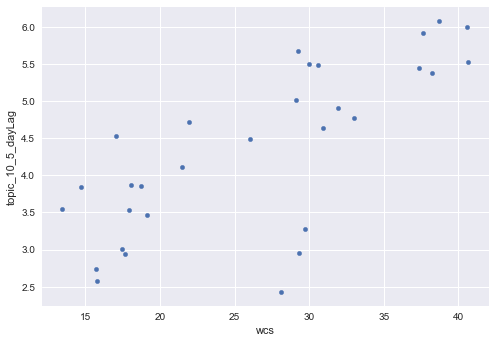

In [328]:
plt.style.use('seaborn')

df_daily_analysis.plot(x='wcs', y='topic_10_5_dayLag', kind='scatter')
plt.show()

In [325]:
X = df_daily_analysis[['articles_5_dayLag','topic_23_5_dayLag','topic_7_5_dayLag','topic_10_5_dayLag']]
Y = df_daily_analysis['wcs']

In [326]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [327]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    wcs   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     13.03
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           7.23e-06
Time:                        09:49:45   Log-Likelihood:                -89.949
No. Observations:                  30   AIC:                             189.9
Df Residuals:                      25   BIC:                             196.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.7499      5.06